Read in halo/stellar mass catalog from TreePM256 simulation, and generate mock survey data sets corresponding to that used in the CLAMATO2017 cross-correlation.

Use stellar masses for the galaxy surveys estimated Yi-Kuan Chiang for an earlier iteration of the galaxy catalog (especially MOSDEF), so am manually scaling the numbers up to match the latest galaxy counts.

In [1]:
import numpy as np
import time as time
import lyafxcorr_kg as xcorr

# Set up matplotlib and use a nicer set of plot parameters
%config InlineBackend.rc = {}
import matplotlib as mpl
mpl.rc('mathtext',fontset='stixsans')
mpl.rc('figure', facecolor="white")
#matplotlib.rc_file("../../templates/matplotlibrc")
import matplotlib.pyplot as plt
#import matplotlib.colors as colors
%matplotlib inline

from astropy.cosmology import FlatLambdaCDM
from astropy.io import fits
from astropy.io import ascii
from astropy.table import Table
from astropy import units as u
from astropy.coordinates import SkyCoord

np.random.seed(452813501)
outdir = '/Users/kheegan/lya/3d_recon/map2017/crosscorr/mocks/'

# Define cosmology
cosmo = FlatLambdaCDM(H0=70, Om0=0.31)
zmin = 2.0
zmid = 2.3
comdist_mean = cosmo.comoving_distance(zmid)
comdist_zmin = cosmo.comoving_distance(zmin)
dcomdist_dz = cosmo.inv_efunc(zmid) *2998. # in Mpc/h

# Galaxy survey parameters
# Specify the [x,y] offsets of each survey relative to the field center, in Mpc/h, 
# and also a guess at the redshift offset and scatter
dx_mosdef = (-8, 0.5)
dy_mosdef = (-10, 11)
deltaz_mosdef = -0.8
sigz_mosdef = 1.5

dx_zdeep = (-29, 29)
dy_zdeep = (-26, 20)
deltaz_zdeep = -1.8
sigz_zdeep   = 3.

dx_vuds = (-27, 15)
dy_vuds = (-26, 22)
deltaz_vuds = -1.
sigz_vuds=3.

dx_clamato = (-15, 15)
dy_clamato = (-12,12)
deltaz_clamato = -1.
sigz_clamato=2.5

dx_3dhst = (-8, 2)
dy_3dhst = (-10, 13)
deltaz_3dhst = -1
sigz_3dhst = 11.

def read_fofp_file(path):
    """
    Read FoF properties file from the give path.
    Just returns a tuple of masses and positions for now, but can be modified
    easily.
    Note that positions are in box size units.

    """
    # get file handle
    fof_file = open(path, "r")

    # use fromfile to read binary chunks
    # number of halos
    num_groups = np.asscalar(np.fromfile(fof_file, dtype="i4", count=1))
    print("{} halos read".format(num_groups))
    # the mass in Msun/h
    masses = np.fromfile(fof_file, dtype="f4", count=num_groups)
    sigma = np.fromfile(fof_file, dtype="f4", count=num_groups)
    v_circ = np.fromfile(fof_file, dtype="f4", count=num_groups)
    min_id = np.fromfile(fof_file, dtype="f4", count=num_groups)
    v_pot_e = np.fromfile(fof_file, dtype="f4", count=num_groups)
    positions = np.fromfile(fof_file, dtype="f4", count=3*num_groups)

    # done reading
    fof_file.close()

    # correct the shape
    positions.shape = (num_groups, 3)

    return (masses, positions)

# Define methods that select galaxies within map boundaries for each survey. 
# Need to be able to handle period boundary conditions


7817171 halos read


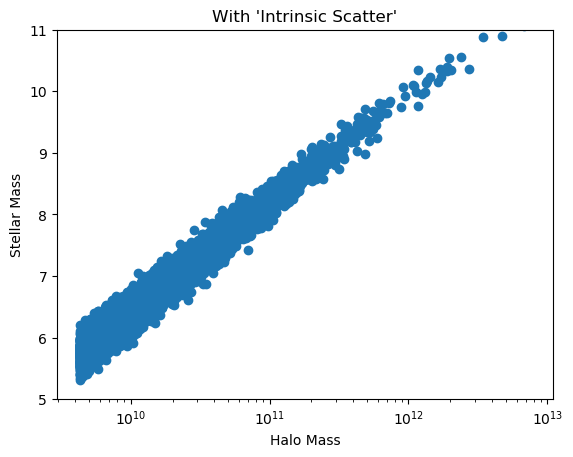

In [2]:
fofp_path = 'treepm_stellar_masses/halos_z25.fofp'
smass_path = 'treepm_stellar_masses/sm_moster_intrinsic_scatter.bin'

masses, positions = read_fofp_file(fofp_path)

smass_file = open(smass_path, "r")

smass = np.fromfile(smass_file, count=len(masses))

smass_file.close()

fig, ax = plt.subplots()

subind = np.arange(len(smass))
subind = np.random.choice(subind, 8000, replace='False')

ax.scatter(masses[subind], smass[subind])
ax.set_xscale("log", nonposx='clip')
ax.set_ylim([5,11])
ax.set_title("With 'Intrinsic Scatter'")
ax.set_xlabel("Halo Mass")
ax.set_ylabel("Stellar Mass")

plt.show()

# The first entry in the file is a junk variable, and also turn h^{-1} M_sun into M_sun while we're at it
positions = np.delete(positions,0,0)
smass = np.delete(smass,0)
masses = np.delete(masses,0)

smass = smass - np.log10(cosmo.h)
masses = masses/cosmo.h

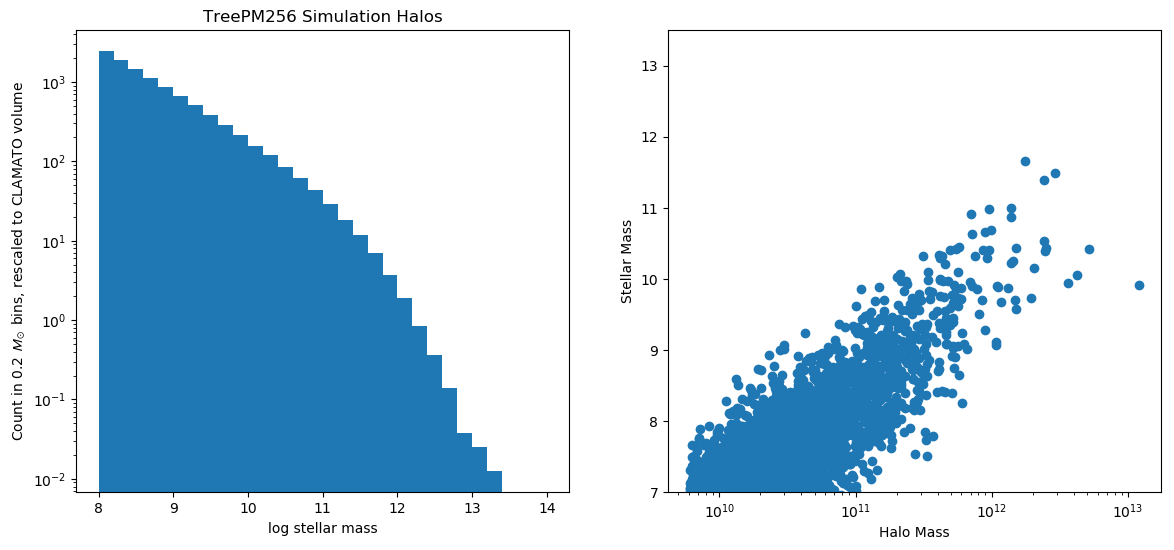

In [3]:
min_mstar = 8.
max_mstar = 14.

fig, (ax, ax2) = plt.subplots(1,2, figsize=(14,6))
binsize=0.2

# Shenanigans are being done here to try to get enough high-mass halos.
# This is done with a combination of 'observational scatter' and outright moving 
# the entire distribution to higher mass
obs_scatt = 0.55 
smass_rand = smass + np.random.normal(0., obs_scatt, len(smass)) + 0.1
histbins = np.arange(min_mstar,max_mstar+binsize, binsize)
#print(histbins)
ax.hist(smass_rand, bins=histbins, weights=np.ones(np.shape(smass),dtype='float')/80.)
ax.set_yscale('log')
ax.set_xlabel('log stellar mass')
ax.set_ylabel(r'Count in 0.2 $M_\odot$ bins, rescaled to CLAMATO volume')

ax.set_title('TreePM256 Simulation Halos')

ax2.scatter(masses[subind], smass_rand[subind])
ax2.set_xscale("log", nonposx='clip')
ax2.set_ylim([7,13.5])
ax2.set_xlabel("Halo Mass")
ax2.set_ylabel("Stellar Mass")

plt.show()


[ 7.   7.2  7.4  7.6  7.8  8.   8.2  8.4  8.6  8.8  9.   9.2  9.4  9.6
  9.8 10.  10.2 10.4 10.6 10.8 11.  11.2 11.4 11.6 11.8 12.  12.2 12.4
 12.6]


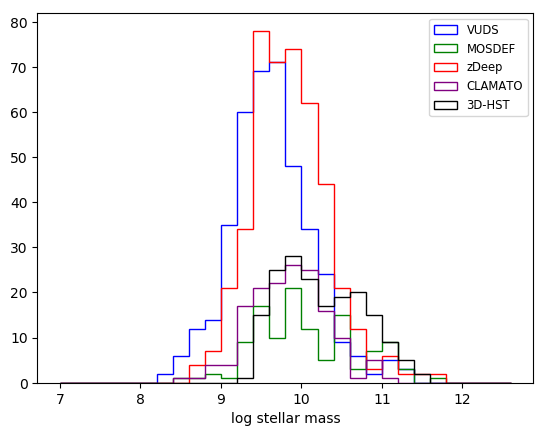

1 NaNs from MOSDEF galaxies
9 NaNs from VUDS galaxies
2 NaNs from zDeep galaxies
0 NaNs from CLAMATO galaxies
1 NaNs from 3D-HST galaxies
Median M_star = 9.961423545667541 for MOSDEF
Median M_star = 9.607491969644045 for VUDS
Median M_star = 9.811885948985875 for zDeep
Median M_star = 9.838085022131871 for CLAMATO
Median M_star = 10.169682885752684 for 3D-HST
<M_star> = 10.072709579352148 for MOSDEF
<M_star> = 9.631830942127538 for VUDS
<M_star> = 9.850837410470994 for zDeep
<M_star> = 9.849167003079868 for CLAMATO
<M_star> = 10.254219354916286 for 3D-HST


In [4]:
gal_cat_fil = 'CLAMATO_2017_Cross-correlation_catalog_w_Mstar.txt'

galcat = ascii.read(gal_cat_fil)

get_mosdef = np.squeeze(np.where(galcat['source'].data == 'MOSDEF'))
get_vuds = np.squeeze(np.where(galcat['source'].data == 'VUDS'))
get_clamato = np.squeeze(np.where(galcat['source'].data == 'CLAMATO'))
get_zdeep = np.squeeze(np.where(galcat['source'].data == 'zDeep'))
get_3dhst = np.squeeze(np.where(galcat['source'].data == '3DHST'))

mstars = galcat['mstar'].data

mstars_mosdef = np.log10(mstars[get_mosdef])
mstars_vuds = np.log10(mstars[get_vuds])
mstars_clamato = np.log10(mstars[get_clamato])
mstars_zdeep = np.log10(mstars[get_zdeep])
mstars_3dhst = np.log10(mstars[get_3dhst])

# limits for the histogram bins
min_mstar = 7.
max_mstar = 12.6

fig, ax = plt.subplots()
binsize=0.2

histbins = np.arange(min_mstar,max_mstar+binsize, binsize)
print(histbins)

ax.hist(mstars_vuds[~np.isnan(mstars_vuds)], bins=histbins, histtype='step',fill=False, 
        color='blue',label='VUDS')
ax.hist(mstars_mosdef[~np.isnan(mstars_mosdef)], bins = histbins, histtype='step', fill=False,
        color='green',label='MOSDEF')
ax.hist(mstars_zdeep[~np.isnan(mstars_zdeep)], bins = histbins, histtype='step', fill=False,
        color='red', label='zDeep')
ax.hist(mstars_clamato[~np.isnan(mstars_clamato)], bins = histbins, histtype='step', fill=False,
        color='purple', label='CLAMATO')
ax.hist(mstars_3dhst[~np.isnan(mstars_3dhst)], bins = histbins, histtype='step', fill=False,
        color='black', label='3D-HST')

ax.set_xlabel('log stellar mass')

plt.legend(fontsize='small')
plt.show()

print('{} NaNs from MOSDEF galaxies'.format(np.sum(np.isnan(mstars_mosdef))))
print('{} NaNs from VUDS galaxies'.format(np.sum(np.isnan(mstars_vuds))))
print('{} NaNs from zDeep galaxies'.format(np.sum(np.isnan(mstars_zdeep))))
print('{} NaNs from CLAMATO galaxies'.format(np.sum(np.isnan(mstars_clamato))))
print('{} NaNs from 3D-HST galaxies'.format(np.sum(np.isnan(mstars_3dhst))))

print('Median M_star = {} for MOSDEF'.format(np.median(mstars_mosdef[~np.isnan(mstars_mosdef)])))
print('Median M_star = {} for VUDS'.format(np.median(mstars_vuds[~np.isnan(mstars_vuds)])))
print('Median M_star = {} for zDeep'.format(np.median(mstars_zdeep[~np.isnan(mstars_zdeep)])))
print('Median M_star = {} for CLAMATO'.format(np.median(mstars_clamato[~np.isnan(mstars_clamato)])))
print('Median M_star = {} for 3D-HST'.format(np.median(mstars_3dhst[~np.isnan(mstars_3dhst)])))

print('<M_star> = {} for MOSDEF'.format(np.mean(mstars_mosdef[~np.isnan(mstars_mosdef)])))
print('<M_star> = {} for VUDS'.format(np.mean(mstars_vuds[~np.isnan(mstars_vuds)])))
print('<M_star> = {} for zDeep'.format(np.mean(mstars_zdeep[~np.isnan(mstars_zdeep)])))
print('<M_star> = {} for CLAMATO'.format(np.mean(mstars_clamato[~np.isnan(mstars_clamato)])))
print('<M_star> = {} for 3D-HST'.format(np.mean(mstars_3dhst[~np.isnan(mstars_3dhst)])))

# Calculate the histograms for later use
hist_mosdef,binedges = np.histogram(mstars_mosdef[~np.isnan(mstars_mosdef)], 
                                    bins=histbins, density=False)
hist_vuds,binedges   = np.histogram(mstars_vuds[~np.isnan(mstars_vuds)], 
                                    bins=histbins, density=False)
hist_zdeep,binedges   = np.histogram(mstars_zdeep[~np.isnan(mstars_zdeep)], 
                                     bins=histbins, density=False)
hist_clamato,binedges   = np.histogram(mstars_clamato[~np.isnan(mstars_clamato)], 
                                       bins=histbins, density=False)
hist_3dhst,binedges   = np.histogram(mstars_3dhst[~np.isnan(mstars_3dhst)], 
                                     bins=histbins, density=False)

[ 8.1  8.3  8.5  8.7  8.9  9.1  9.3  9.5  9.7  9.9 10.1 10.3 10.5 10.7
 10.9 11.1 11.3 11.5 11.7 11.9 12.1]
117.25785381709575
117


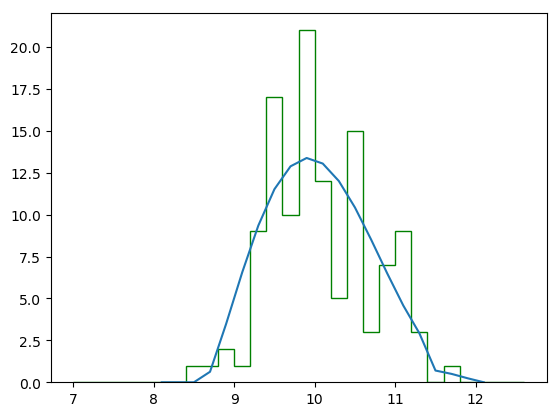

In [5]:
binctr = (binedges[:-1] + binedges[1:])/2.
# Try to fit a polynomial to the MOSDEF distribution which is quite jagged
xx = binctr[5:-2]
print(xx)
hist_tmp = hist_mosdef[5:-2]
p_md = np.polyfit(xx, hist_tmp, 5)
#polyfit =  p_md[0]*xx**4 + p_md[1]*xx**3 +p_md[2]*xx**2 + p_md[3]*xx + p_md[4]
polyfit = p_md[0]*xx**5 + p_md[1]*xx**4 + p_md[2]*xx**3 +p_md[3]*xx**2 + p_md[4]*xx + p_md[5]

# Manually fiddle with the fitted distribution :/
polyfit[np.where(polyfit < 0)] = 0
polyfit[0]=0
polyfit[len(polyfit)-4]=0.7
polyfit[len(polyfit)-3]=0.5

print(np.sum(polyfit))
print(len(mstars_mosdef[~np.isnan(mstars_mosdef)]))
fig, ax = plt.subplots()
ax.hist(mstars_mosdef[~np.isnan(mstars_mosdef)], bins = histbins, histtype='step', fill=False,
        color='green',label='MOSDEF')
ax.plot(xx, polyfit)

plt.show()

hist_mosdef_fit = hist_mosdef.copy()
hist_mosdef_fit[5:-2] = polyfit

184.93891401961446
179


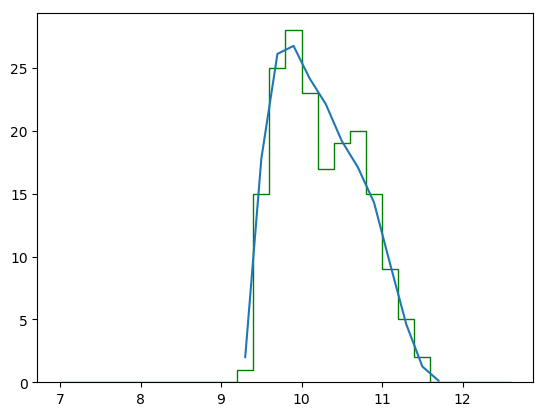

In [6]:
# Try to fit a polynomial to the 3dhst distribution which is quite jagged
xx = binctr[11:-4]
print, xx
hist_tmp = hist_3dhst[11:-4]
p_3d = np.polyfit(xx, hist_tmp, 5)
#polyfit =  p_md[0]*xx**4 + p_md[1]*xx**3 +p_md[2]*xx**2 + p_md[3]*xx + p_md[4]
polyfit = p_3d[0]*xx**5 + p_3d[1]*xx**4 + p_3d[2]*xx**3 +p_3d[3]*xx**2 + p_3d[4]*xx + p_3d[5]

# Manually fiddle with the fitted distribution :/
polyfit[np.where(polyfit < 0)] = 0
polyfit[0]=2
polyfit[2] = polyfit[2]+2
polyfit[3] = polyfit[3]+2
polyfit[4:6] = polyfit[4:6]+1

polyfit[-3] = polyfit[-3]-1
polyfit[-4] = polyfit[-4]-1


print(np.sum(polyfit))
print(len(mstars_3dhst[~np.isnan(mstars_3dhst)]))
fig, ax = plt.subplots()
ax.hist(mstars_3dhst[~np.isnan(mstars_3dhst)], bins = histbins, histtype='step', fill=False,
        color='green',label='3DHST')
ax.plot(xx, polyfit)

plt.show()

hist_3dhst_fit = hist_3dhst.copy()
hist_3dhst_fit[11:-4] = polyfit

In [7]:
# Rescale the numbers to match actual n_gal used in the cross-correlation
ngal_mosdef = 195
ngal_vuds = 435
ngal_zdeep = 506
ngal_clamato = 165
ngal_3dhst = 322

hist_mosdef = np.rint(hist_mosdef_fit * ngal_mosdef/np.sum(hist_mosdef_fit)).astype('int')
hist_vuds = np.rint(hist_vuds * ngal_vuds/np.sum(hist_vuds)).astype('int')
hist_zdeep = np.rint(hist_zdeep * ngal_zdeep/np.sum(hist_zdeep)).astype('int')
hist_clamato = np.rint(hist_clamato * ngal_clamato/np.sum(hist_clamato)).astype('int')
hist_3dhst = np.rint(hist_3dhst_fit * ngal_3dhst/np.sum(hist_3dhst_fit)).astype('int')

print('{} galaxies from MOSDEF'.format(np.sum(hist_mosdef)))
print('{} galaxies from VUDS'.format(np.sum(hist_vuds)))
print('{} galaxies from zDeep'.format(np.sum(hist_zdeep)))
print('{} galaxies from clamato'.format(np.sum(hist_clamato)))
print('{} galaxies from 3dhst'.format(np.sum(hist_3dhst)))

# Hack the histogram so that the high-mass end of the bins is effectively open-ended
hist_mosdef_fit = hist_mosdef_fit[:-4]
hist_vuds   = hist_vuds[:-4]
hist_zdeep  = hist_zdeep[:-4]
hist_clamato = hist_clamato[:-4]
hist_3dhst_fit   = hist_3dhst_fit[:-4]
binedges = binedges[:-4]
binedges[-1]= 12.2

nbins = len(hist_mosdef_fit)

194 galaxies from MOSDEF
434 galaxies from VUDS
506 galaxies from zDeep
164 galaxies from clamato
322 galaxies from 3dhst


In [8]:
# Generate mock redshift catalogs

# We will create mocks over these number of distinct fields
nmock_x = 8
nmock_y = 10
nloop = 10
nmocks = nmock_x * nmock_y * nloop

width_x = 30. # Mpc/h
width_y = 24. # Mpc/h

# Generate lists indicating the CLAMATO field boundaries and centers
xlow_field = np.arange(nmock_x)*width_x
xhi_field = (np.arange(nmock_x) + 1.)*width_x 
xcen_field = np.ndarray.tolist((xlow_field+xhi_field)/2.)

ylow_field = np.arange(nmock_y) * width_y
yhi_field  = (np.arange(nmock_y)+1.)* width_y
ycen_field = np.ndarray.tolist((ylow_field+yhi_field)/2.)

# Grab all halos within this footprint
xhalos = positions[:,0]*256.
yhalos = positions[:,1]*256.
zhalos = positions[:,2]*256.

# Reflect the 4 sides + 4 corners in the [x,y] dimension
xleft = xhalos-256.
xright = xhalos+256.
ytop = yhalos+256.
ybottom=yhalos-256.

xhalos = np.concatenate( (xhalos, xleft, xright,    xhalos,    xhalos,
                         xleft, xright, xright, xleft) )
yhalos = np.concatenate( (yhalos, yhalos,       yhalos,     ybottom, ytop,
                         ybottom, ybottom, ytop, ytop) )
zhalos = np.concatenate( (zhalos, zhalos,       zhalos,      zhalos,       zhalos,
                         zhalos,   zhalos,     zhalos,       zhalos) )
smass_rand=np.concatenate( (smass_rand, smass_rand, smass_rand, smass_rand, smass_rand,
                           smass_rand,  smass_rand, smass_rand,  smass_rand))

Looping across the individual subvolumes, select halo from sim that matches each survey. We loop across the histogram bins in reverse order, and if there's a deficit in halos at the high mass then they will be made up in the lower-mass bins 

In [9]:

def select_halos(hist_surv, dx_surv, dy_surv, delta_z, sigma_z):
    
    # Define field footprint
    xlow_tmp, xhi_tmp = dx_surv 
    xlow_tmp += xcen_field_tmp
    xhi_tmp  += xcen_field_tmp

    ylow_tmp, yhi_tmp = dy_surv 
    ylow_tmp += ycen_field_tmp
    yhi_tmp  += ycen_field_tmp

    # Grab all halos within the present survey footprint
    halos_here = np.all(np.column_stack([(xhalos > xlow_tmp), (xhalos <= xhi_tmp),
                                         (yhalos > ylow_tmp), (yhalos <= yhi_tmp)]), 
                        axis=1)

    nh_tmp = np.sum(halos_here)
    #print('{} halos within footprint'.format(nh_tmp))

    # Positions and stellar masses of all halos within footprint
    xh_tmp = xhalos[halos_here]
    yh_tmp = yhalos[halos_here]
    zh_tmp = zhalos[halos_here]
    smass_tmp = smass_rand[halos_here]
        
    # Here, we also move half of the halos to the extended, second z-half of the volume
    ind_half_tmp = np.random.choice(np.arange(nh_tmp), 
                                    size=np.floor(0.5*nh_tmp).astype('int'), 
                                    replace=False)
    zh_tmp[ind_half_tmp] = zh_tmp[ind_half_tmp] + 256.

    #Initialize array to store indices of selected halos
    mock_ind_surv = np.asarray([], dtype=np.int32)

    # Select galaxies by mass by looping over histogram of desired survey
    hist_surv_copy = hist_surv.copy()
    ind_nonzero = np.where(hist_surv_copy > 0)[0] # List of nonzero array elements
    for i in reversed(np.arange(nbins)):
        if hist_surv_copy[i] != 0:
            getmass, = np.where((smass_tmp > binedges[i]) & (smass_tmp <= binedges[i+1]))
            if len(getmass) < hist_surv_copy[i]:

                draw_massbin = getmass
                # Distribute excess galaxy counts to lower mass bins
                ct_excess = hist_surv_copy[i] - len(getmass)
                #print(ct_excess)
                draw_redist = np.random.choice(ind_nonzero[:i-1], size=ct_excess, 
                                               replace=True)
                hist_surv_copy[draw_redist]+=1
            else:
                draw_massbin=np.random.choice(getmass, size=hist_surv_copy[i],
                                              replace=False)
            mock_ind_surv = np.append(mock_ind_surv, draw_massbin)
        
    xh_surv = xh_tmp[mock_ind_surv]
    yh_surv = yh_tmp[mock_ind_surv]
    # For z-dimension, also introduce redshift offset and scatter
    zh_surv = zh_tmp[mock_ind_surv] + np.random.normal(delta_z, sigma_z, 
                                                       size=len(mock_ind_surv))

    smass_surv = smass_tmp[mock_ind_surv]
    return(xh_surv, yh_surv, zh_surv, smass_surv)
        


ngaldist_3dhst = np.asarray([], dtype=np.int32)
ngaldist_mosdef = np.asarray([], dtype=np.int32)
ngaldist_zdeep = np.asarray([], dtype=np.int32)
ngaldist_vuds = np.asarray([], dtype=np.int32)
ngaldist_clamato = np.asarray([], dtype=np.int32)

ctr = 1
tstart = time.time()

for i in np.arange(nloop):
    for xcen_field_tmp in xcen_field:
        for ycen_field_tmp in ycen_field:
        
            x_3dhst, y_3dhst, z_3dhst, smass_3dhst = select_halos(hist_3dhst, dx_3dhst,
                                                                 dy_3dhst, deltaz_mosdef,
                                                                 sigz_3dhst)
        
            x_mosdef, y_mosdef, z_mosdef, smass_mosdef = select_halos(hist_mosdef, dx_mosdef, 
                                                                      dy_mosdef, 
                                                                      deltaz_mosdef, 
                                                                      sigz_mosdef)
            x_zdeep, y_zdeep, z_zdeep, smass_zdeep = select_halos(hist_zdeep, dx_zdeep,
                                                                 dy_zdeep, deltaz_zdeep,
                                                                 sigz_zdeep)
            x_vuds, y_vuds, z_vuds, smass_vuds = select_halos(hist_vuds, dx_vuds, 
                                                             dy_vuds, deltaz_vuds, 
                                                             sigz_vuds)
            x_clamato, y_clamato, z_clamato, smass_clamato = \
            select_halos(hist_clamato, dx_clamato, dy_clamato, deltaz_clamato, sigz_clamato)
        
            ngal_3dhst = len(smass_3dhst)
            ngal_mosdef = len(smass_mosdef)
            ngal_zdeep = len(smass_zdeep)
            ngal_vuds = len(smass_vuds)
            ngal_clamato = len(smass_clamato)
        
            x_all = np.concatenate((x_3dhst, x_mosdef, x_zdeep, x_vuds, x_clamato))
            y_all = np.concatenate((y_3dhst, y_mosdef, y_zdeep, y_vuds, y_clamato))
            z_all = np.concatenate((z_3dhst, z_mosdef, z_zdeep, z_vuds, z_clamato))
            smass_all = np.concatenate((smass_3dhst, smass_mosdef, smass_zdeep,
                                    smass_vuds, smass_clamato))
        
            # Convert 3D positions in RA, Dec, and redshift
            ra_all = 180./np.pi * x_all/comdist_mean.value/cosmo.h
            dec_all = 180./np.pi * y_all/comdist_mean.value/cosmo.h
            red_all = zmin + z_all/dcomdist_dz
            # Generate array of survey names
            source_all = np.concatenate((np.asarray(['3DHST']*ngal_3dhst),
                                        np.asarray(['MOSDEF']*ngal_mosdef),
                                        np.asarray(['zDeep']*ngal_zdeep),
                                        np.asarray(['VUDS']*ngal_vuds),
                                        np.asarray(['CLAMATO']*ngal_clamato)))
        
            # Output to file
            output_table = Table([ra_all, dec_all, red_all, source_all, smass_all],
                                names=('ra', 'dec', 'zspec', 'source', 'stellar_mass'),
                                dtype=('f8', 'f8', 'f4', 'U', 'f8') )
            output_table['ra'].unit=u.degree
            output_table['dec'].unit = u.degree
            outname = outdir + 'cat_galmock_nonuniq_{0:03d}.dat'.format(ctr)
            ascii.write(output_table, outname, format='ipac', overwrite=True)
        
            # Build up histogram tracking the number of galaxies in each realization
            ngaldist_3dhst = np.append(ngaldist_3dhst, ngal_3dhst)
            ngaldist_mosdef = np.append(ngaldist_mosdef, ngal_mosdef)
            ngaldist_zdeep = np.append(ngaldist_zdeep, ngal_zdeep)
            ngaldist_vuds  = np.append(ngaldist_vuds, ngal_vuds)
            ngaldist_clamato = np.append(ngaldist_clamato, ngal_clamato)
        
            if ctr ==1:
                print('Time to generate one mock = {0}s'.format(time.time()-tstart))
            print('i={0:d},x={1:5.2f} Mpc/h, y={2:5.2f} Mpc/h'.format(ctr,xcen_field_tmp, ycen_field_tmp))
            ctr += 1

Time to generate one mock = 7.050822973251343s
i=1,x=15.00 Mpc/h, y=12.00 Mpc/h
i=2,x=15.00 Mpc/h, y=36.00 Mpc/h
i=3,x=15.00 Mpc/h, y=60.00 Mpc/h
i=4,x=15.00 Mpc/h, y=84.00 Mpc/h
i=5,x=15.00 Mpc/h, y=108.00 Mpc/h
i=6,x=15.00 Mpc/h, y=132.00 Mpc/h
i=7,x=15.00 Mpc/h, y=156.00 Mpc/h
i=8,x=15.00 Mpc/h, y=180.00 Mpc/h
i=9,x=15.00 Mpc/h, y=204.00 Mpc/h
i=10,x=15.00 Mpc/h, y=228.00 Mpc/h
i=11,x=45.00 Mpc/h, y=12.00 Mpc/h
i=12,x=45.00 Mpc/h, y=36.00 Mpc/h
i=13,x=45.00 Mpc/h, y=60.00 Mpc/h
i=14,x=45.00 Mpc/h, y=84.00 Mpc/h
i=15,x=45.00 Mpc/h, y=108.00 Mpc/h
i=16,x=45.00 Mpc/h, y=132.00 Mpc/h
i=17,x=45.00 Mpc/h, y=156.00 Mpc/h
i=18,x=45.00 Mpc/h, y=180.00 Mpc/h
i=19,x=45.00 Mpc/h, y=204.00 Mpc/h
i=20,x=45.00 Mpc/h, y=228.00 Mpc/h
i=21,x=75.00 Mpc/h, y=12.00 Mpc/h
i=22,x=75.00 Mpc/h, y=36.00 Mpc/h
i=23,x=75.00 Mpc/h, y=60.00 Mpc/h
i=24,x=75.00 Mpc/h, y=84.00 Mpc/h
i=25,x=75.00 Mpc/h, y=108.00 Mpc/h
i=26,x=75.00 Mpc/h, y=132.00 Mpc/h
i=27,x=75.00 Mpc/h, y=156.00 Mpc/h
i=28,x=75.00 Mpc/h, y=180.00 

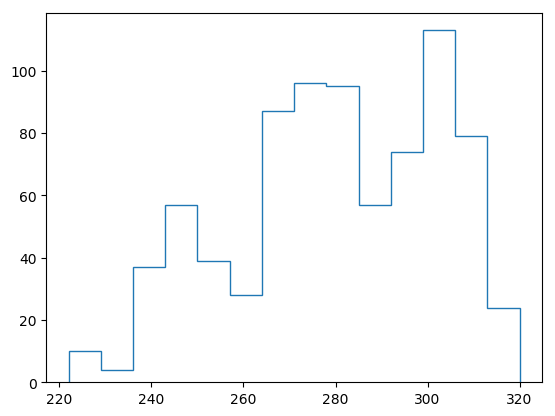

279.81625


In [10]:
        
fig, ax = plt.subplots()

ax.hist(ngaldist_3dhst, bins='auto', histtype='step')
plt.show()

print(np.mean(ngaldist_3dhst))

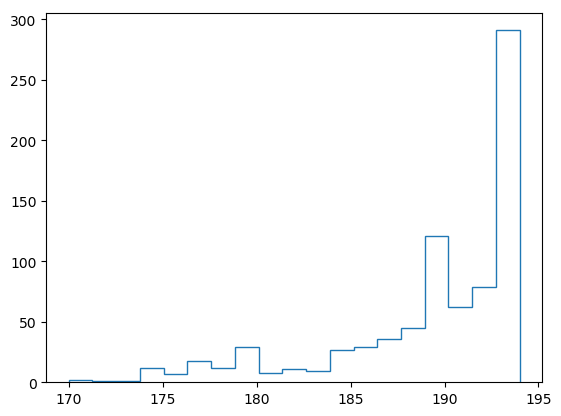

189.3925


In [11]:
fig, ax = plt.subplots()

ax.hist(ngaldist_mosdef, bins='auto', histtype='step')
plt.show()

print(np.mean(ngaldist_mosdef))

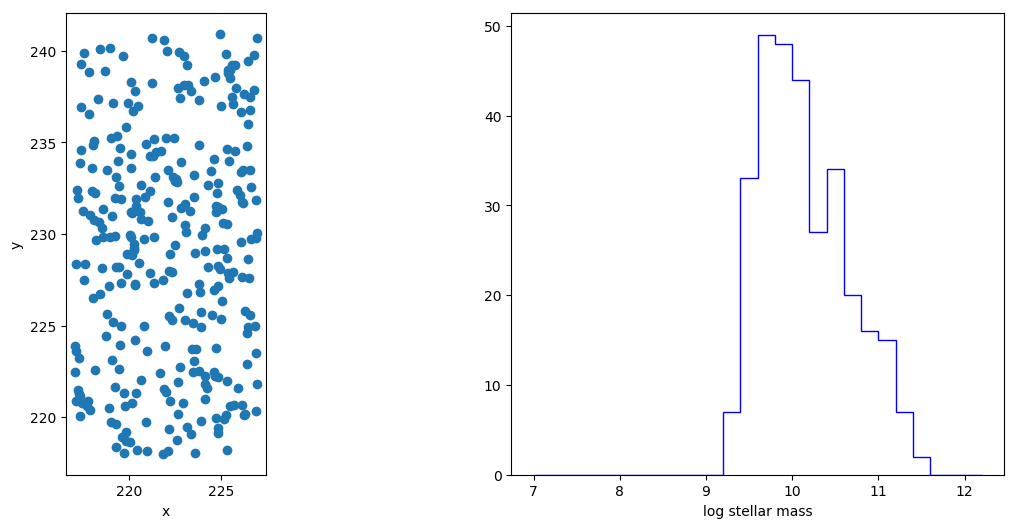

302


In [12]:

#for i in mock_ind_mosdef:
#    print(xh_tmp[i], yh_tmp[i], zh_tmp[i])
    
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(14,6))

ax1.scatter(x_3dhst, y_3dhst)
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_aspect('equal')

ax2.hist(smass_3dhst, bins=binedges, histtype='step',fill=False, 
        color='blue')
ax2.set_xlabel('log stellar mass')

plt.show()

print(len(smass_3dhst))

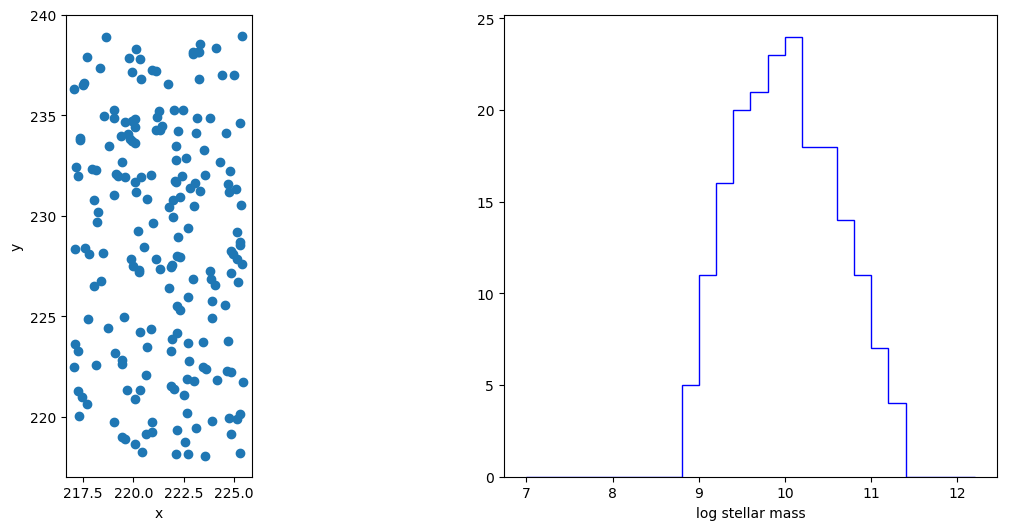

192


In [13]:
#for i in mock_ind_mosdef:
#    print(xh_tmp[i], yh_tmp[i], zh_tmp[i])
    
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(14,6))

ax1.scatter(x_mosdef, y_mosdef)
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_aspect('equal')

ax2.hist(smass_mosdef, bins=binedges, histtype='step',fill=False, 
        color='blue')
ax2.set_xlabel('log stellar mass')


plt.show()

print(len(smass_mosdef))